In [20]:
import numpy as np       # the NumPy library for fast matrix and vector data types and math operations
import matplotlib.pyplot as plt   # functions for plotting, loaded under a convenient name alias 'plt'
from pylab import plot, show, xlabel, ylabel, legend, semilogy,semilogx, grid, xlim, ylim, title,savefig, minorticks_on, figtext,text, errorbar
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import csv
import pandas as pd
from astropy import modeling
from scipy import optimize
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.integrate import quad
import datetime
from datetime import timedelta
from datetime import datetime
from scipy.optimize import curve_fit


Import Thomson data

In [47]:
def gaussian(x, amplitude, mean, stddev,offset): #make a funciton that returns a gaussian
    return amplitude * np.exp(-((x - mean)/ stddev)**2/ 2)+offset

def integrand(x, mean, stddev,offset):
    return (np.exp(-((x - mean)/ stddev)**2)+offset)
x=np.arange(-25,25,0.1)


In [3]:
shotnr=[28925,28928,28935,28939,28943,28947,28950]
def TS(expnum):
    filename=('Thomson_2021-06-10_#' + str(shotnr[expnum-1]) + '.txt')
    df = pd.read_csv(filename, delimiter = "\t", skiprows=5, warn_bad_lines=True, error_bad_lines=False) #remove lines that do not have 5 columns 
    data_columns=df.columns.values
    num_df = (df.drop(data_columns, axis=1).join(df[data_columns].apply(pd.to_numeric, errors='coerce'))) #remove the lines that are not fully numerical
    num_df = num_df[num_df[data_columns].notnull().all(axis=1)] #remove the lines that are not fully numerical
    num_df.index=list(range(0, len(num_df))) #sets the indec to start at 0 and increase by 1, row number

    # There are 3 Thomson measurements per exp so we need to see which times correspond to thebegining and end of each exp. 
    difference = num_df.diff(axis=0) #difference between two consecutive rows
    t12=num_df[difference.iloc[:,0]<0].index.values #the 1st column is the position which per measurement always increases, so if the diff is negative it means we have a new measurement 
    T1=num_df.iloc[0:t12[0]]
    T2=num_df.iloc[t12[0]:t12[1]]
    T3=num_df.iloc[t12[1]:len(num_df)]

    popt, pcov = optimize.curve_fit(gaussian, T3.iloc[:,0], T3.iloc[:,2],[3,3,1,0],bounds=((0, -np.inf,0, -np.inf),(np.inf,np.inf,np.inf, np.inf))) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    popt_n, pcov_n = optimize.curve_fit(gaussian, T3.iloc[:,0], (T3.iloc[:,1]*1e-19),[2,3,6,3]) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    #qprof=gaussian(x, *popt)**(1.5)*gaussian(x, *popt_n)
    return T3,popt,popt_n

T3,popt,popt_n=TS(5)


In [77]:
x=np.arange(-25,25,0.1)
shotnr =[28924,28927,28934,28938,28942,28946,28950]
nrshots=[    3,    4,    4,    4,    4,    4,    1]
expnum=7

Ts = pd.DataFrame()
for i in range(0,nrshots[expnum-1]):
    filename=('Thomson_2021-06-10_#' + str(shotnr[expnum-1]+i) + '.txt')
    df = pd.read_csv(filename, delimiter = "\t", skiprows=5, warn_bad_lines=True, error_bad_lines=False) #remove lines that do not have 5 columns 
    data_columns=df.columns.values
    num_df = (df.drop(data_columns, axis=1).join(df[data_columns].apply(pd.to_numeric, errors='coerce'))) #remove the lines that are not fully numerical
    num_df = num_df[num_df[data_columns].notnull().all(axis=1)] #remove the lines that are not fully numerical
    num_df.index=list(range(0, len(num_df))) #sets the indec to start at 0 and increase by 1, row number
    # There are 3 Thomson measurements per exp so we need to see which times correspond to thebegining and end of each exp. 
    difference = num_df.diff(axis=0) #difference between two consecutive rows
    t12=num_df[difference.iloc[:,0]<0].index.values #the 1st column is the position which per measurement always increases, so if the diff is negative it means we have a new measurement 
    if expnum==7:
        Ts=pd.concat([Ts,num_df.iloc[0:t12[0]],num_df.iloc[t12[0]:len(num_df)]])
    else:
        Ts=pd.concat([Ts,num_df.iloc[0:t12[0]],num_df.iloc[t12[0]:t12[1]],num_df.iloc[t12[1]:len(num_df)]])

popt, pcov = optimize.curve_fit(gaussian, Ts.iloc[:,0], Ts.iloc[:,2],[3,3,1,0],bounds=((0, -np.inf,0, -np.inf),(np.inf,np.inf,np.inf, np.inf))) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
popt_n, pcov_n = optimize.curve_fit(gaussian, Ts.iloc[:,0], (Ts.iloc[:,1]*1e-19),[2,3,6,3]) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]



There are 3 Thomson measurements per exp so we need to see which times correspond to thebegining and end of each exp. 

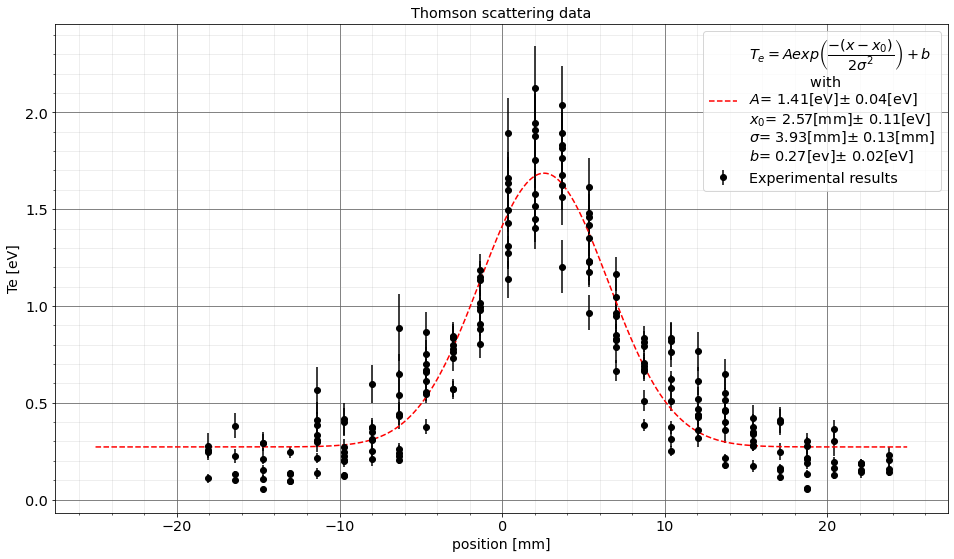

In [58]:
# fig,ax = plt.subplots()
# ax.plot(T3.iloc[:,0],T3.iloc[:,2],'-or')
# ax.plot(x, gaussian(x, *popt),'--r')
# xlabel('position [mm]', fontsize=14)
# ylabel('Te [eV]', color="red",fontsize=14)

# grid(b=True, which='major', color='#666666')
# minorticks_on()
# grid(b=True, which='minor', color='#999999', alpha=0.2)

# ax2=ax.twinx()
# ax2.plot(T3.iloc[:,0],T3.iloc[:,1]*1e-19,'-ob')
# ax2.set_ylabel(r'$n_e \times 10^{-19} [ m^{-3}]$', color="blue",fontsize=14)
# ax2.plot(x, gaussian(x, *popt_n),'--b')
# title('Thomson scattering data')
# #savefig('TS_first.png', dpi=1000)
# show()


Fit=(popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]))
Fit_n=(popt_n[0],np.sqrt(pcov_n[0,0]),popt_n[1],np.sqrt(pcov_n[1,1]),popt_n[2],np.sqrt(pcov_n[2,2]),popt_n[3],np.sqrt(pcov_n[3,3]))


errorbar(Ts.iloc[:,0],Ts.iloc[:,2], yerr=Ts.iloc[:,4], fmt='o', color='k', label='Experimental results')
plot(x, gaussian(x, *popt),'--r',label=r"$T_e=Aexp\left(\dfrac{-(x-x_0)}{2\sigma^2}\right)+b$" "\n" "$\qquad\qquad$ with" "\n" "$A$=%5.2f[eV]$\pm$%5.2f[eV]" "\n" "$x_0$=%5.2f[mm]$\pm$%5.2f[eV]" "\n" "$\sigma$=%5.2f[mm]$\pm$%5.2f[mm]" "\n" "$b$=%5.2f[ev]$\pm$%5.2f[eV]" % (Fit))
xlabel('position [mm]', fontsize=14)
ylabel('Te [eV]',fontsize=14)
title('Thomson scattering data')
legend()
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
# savefig('TS_Te.png', dpi=1000)
show()


# plt.errorbar(T3.iloc[:,0],T3.iloc[:,1]*1e-19, yerr=T3.iloc[:,3]*1e-19, color='k', label='Experimental results')
# plot(x, gaussian(x, *popt_n),'--r',label=r"$n_e=Aexp\left(\dfrac{-(x-x_0)}{2\sigma^2}\right)+b$" "\n" "$\qquad\qquad$ with" "\n" r"$A$=%5.2f$\times 10^{-19}[m^{-3}] \pm$%5.2f$\times 10^{-19}[m^{-3}]$" "\n" "$x_0$=%5.2f[mm]$\pm$%5.2f[eV]" "\n" "$\sigma$=%5.2f[mm]$\pm$%5.2f[mm]" "\n" r"$b$=%5.2f$\times 10^{-19}[m^{-3}]\pm$%5.2f$\times 10^{-19}[m^{-3}]$" % (Fit_n))
# xlabel('position [mm]', fontsize=14)
# ylabel(r'$n_e \times 10^{-19} [ m^{-3}]$',fontsize=14)
# title('Thomson scattering data')
# legend()
# grid(b=True, which='major', color='#666666')
# minorticks_on()
# grid(b=True, which='minor', color='#999999', alpha=0.2)
# # savefig('TS_ne.png', dpi=1000)
# show()
